# Bio-BERT Transformer Trainer


## Set Up

In [1]:
# !pip install transformers datasets accelerate evaluate gensim==4.2.0 numpy==1.22.4 rdkit==2023.3.1

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# cd drive/MyDrive/w210_Capstone/
%cd ..

/home/ubuntu/capstone-project


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, AutoConfig
from transformers import AdamW, get_cosine_schedule_with_warmup
from transformers import BertConfig, BertModel
from datasets import load_metric, load_dataset

import gensim
import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

# from logging import warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
if torch.cuda.is_available():
    device = "cuda"
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = "cpu"

Number of GPU(s) available: 1
GPU device name: NVIDIA A10G


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

## Training Bio-BERT with Trainer & Hugging Face

### Build DataSet

In [6]:
## Define hyperparameters
BATCH_SIZE = 32
EPOCHS = 4
# LEARNING_RATE = 1e-3
LEARNING_RATE = 0.01
# LEARNING_RATE = 0.0963
WEIGHT_DECAY = 1e-4
# WEIGHT_DECAY = 0.01
WORKERS = int(os.cpu_count())

In [7]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary.csv'
test_file = 'data/binary_ddi/ddi_test_binary.csv'

dataset = load_dataset('csv',
                       sep="\t",
                       data_files={'train': train_file, 'validation': dev_file,'test': test_file})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/csv/default-810e63994caf0135/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 300000
    })
    validation: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 238072
    })
    test: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 186753
    })
})

In [10]:
df_train = pd.read_csv(train_file, sep='\t')
df_dev = pd.read_csv(dev_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')
print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()

mean length of smiles1: 62.479706666666665
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.77145
min length of smiles2: 3
max length of smiles2: 748
Value Counts of Labels in Train Set:


interaction_type
1    150000
0    150000
Name: count, dtype: int64

In [9]:
## Load the pre-trained BioBERT tokenizer
# model_checkpoint = "dmis-lab/biobert-base-cased-v1.1"
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"

# Tokenize & Pre-process Data
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [9]:
from transformers import PretrainedConfig

class BioClinicalBertConfig(PretrainedConfig):
    model_type = "bert"

    def __init__(
        self,
        hidden_size1: int = 68, 
        hidden_size2: int = 54, 
        hidden_size3: int = 40, 
        hidden3_dropout: float = 0.1, 
        unfreeze: bool = False,
        layer_norm_eps: float = 1e-12,
        pad_token_id: int = 0,
        position_embedding_type: str = "absolute",
        use_cache: bool = True,
        **kwargs,
    ):
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden3_dropout = hidden3_dropout
        self.unfreeze = unfreeze
        self.layer_norm_eps = layer_norm_eps
        self.pad_token_id = pad_token_id
        self.position_embedding_type = position_embedding_type
        self.use_cache = use_cache
        super().__init__(**kwargs)

config = BioClinicalBertConfig.from_pretrained(
    model_checkpoint,
    label2id={"NEGATIVE": 0, "POSITIVE": 1},
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    unfreeze=False,
    
)

In [10]:
print(config)

BioClinicalBertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden3_dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "hidden_size1": 68,
  "hidden_size2": 54,
  "hidden_size3": 40,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "unfreeze": false,
  "use_cache": true,
  "vocab_size": 28996
}



In [11]:
# Create Combined SMILES column, seperated by [SEP] token between SMILES1 & SMILES2
def preprocess_data(examples):
    source_inputs = []
    for sm1, sm2 in zip(examples['smiles1'], examples['smiles2']):
        # Ensure feeding both smile 1 & smiles 2 into input by truncating if the smiles are too loong
        source_input = "[CLS]" + sm1[:250] + "[SEP]" + sm2[:250] + "[SEP]"
        source_inputs.append(source_input)
    model_inputs = tokenizer(source_inputs,
                             max_length=512,
                             padding="max_length",
                             truncation=True,
                             return_token_type_ids=False,
                             return_tensors='pt'
                             )

    model_inputs["labels"] = examples['interaction_type']

    return model_inputs

In [12]:
encoded_train_ds = dataset['train'].map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)
encoded_val_ds_full = dataset['validation'].map(preprocess_data, batched=True, remove_columns=dataset['validation'].column_names)
encoded_val_ds = encoded_val_ds_full.select(indices=range(30000))  # Subset to smaller valset for faster training
encoded_test_ds = dataset['test'].map(preprocess_data, batched=True, remove_columns=dataset['test'].column_names)

encoded_val_ds

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-7c7fda65b4fd85b3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-302195fe960a0721.arrow


Map:   0%|          | 0/238072 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-7c7fda65b4fd85b3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-88c4a77060bf653b.arrow


Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 30000
})

In [13]:
encoded_val_ds[0]['labels']

1

In [15]:
len(encoded_train_ds)/BATCH_SIZE

2343.75

### Build Model, Set up Trainer

In [13]:
from transformers import BertPreTrainedModel, BertModel

class BioClinicalBertClassification(BertPreTrainedModel):
    config_class = BioClinicalBertConfig
    
    def __init__(self, config, num_labels=2):
        super(BioClinicalBertClassification, self).__init__(config)
        self.bert_model = BertModel(config=config)
        self.num_labels = num_labels

        # Unfreeze the last BERT transformer layer
        if config.unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if config.unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True
        else:
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_layer = nn.Linear(self.bert_hidden_size, config.hidden_size1)
        self.hidden_layer2 = nn.Linear(config.hidden_size1, config.hidden_size2)
        self.hidden_layer3 = nn.Linear(config.hidden_size2, config.hidden_size3)

        self.drop_out = nn.Dropout(config.hidden3_dropout)

        if self.num_labels >= 2:
            self.classification = nn.Linear(config.hidden_size3, self.num_labels)
        else:
            self.classification = nn.Linear(config.hidden_size3, 1)
            
        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)
        
        # pooler_token = bert_output[1]
        pooler_token = bert_output[0][:,0]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)      

        if self.num_labels >= 2:
            logits = self.classification(hidden_ouput)

        else:           
            logits = self.Sigmoid(self.classification(hidden_ouput))
            logits = logits.flatten()
        
        if self.num_labels == 1 and labels is not None:
            loss_fct = nn.BCELoss()
            loss = loss_fct(logits, labels.float())
            return {"loss": loss, "logits": logits}
        
        if self.num_labels >= 2 and labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

In [14]:
BioClinicalBertConfig.register_for_auto_class()
BioClinicalBertClassification.register_for_auto_class("AutoModelForSequenceClassification")

In [15]:
# Load Metric
metric = load_metric('glue', 'sst2')
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

In [16]:
# Test metric calculation
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.53125}

In [17]:
def compute_metrics(eval_pred, num_labels=2):
    predictions, labels = eval_pred
        
    if num_labels >= 2:
        # probability
        # softmax = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)
        # scores = softmax[:, 1]
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions =(np.array(predictions) >= 0.5).astype(float)
        # scores = np.array(predictions)

    # Accuracy
    result = metric.compute(predictions=predictions, references=labels)

    # Add F2 Score
    result["f2"] = metrics.fbeta_score(labels, predictions, average="binary", pos_label=1, beta=2)

    # Add Recall
    result["recall"] = metrics.recall_score(labels, predictions, average="binary", pos_label=1)

    # Add Precision
    result["precision"] = metrics.precision_score(labels, predictions, average="binary", pos_label=1)

    # Matthew Correlation
    result["mcc"] = metrics.matthews_corrcoef(labels, predictions)

    # Area Under Precision, Recall Curve
    # precisions, recalls, thresholds = precision_recall_curve(labels, scores)
    # result["AUPRC"] = auc(precisions, recalls)
    
    return {k: round(v, 4) for k, v in result.items()}

In [18]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [19]:
# Model Initilization
model = BioClinicalBertClassification(config)

# # Pretrain model weights
# pretrained_model = AutoModel.from_pretrained(model_checkpoint)
# # Load pre-train weights to BioBert model
# model.bert_model.load_state_dict(pretrained_model.state_dict())

# Load training weights checkpoint, for continue training
# pretrained_weights = torch.load('models/BioBERTFrozen.pth')
pretrained_weights = torch.load('models/Bio_ClinicalBERT_DDI_2heads2.pth')
model.load_state_dict(pretrained_weights )



# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_checkpoint, config=config
# )

# Print out models params for checking
params = list(model.named_parameters())
for p in params[-20:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Optimizer & Schedular
# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, 
#                   weight_decay=WEIGHT_DECAY)
# scheduler = get_cosine_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=10,
#                                             num_training_steps=30000)

# Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = round(EPOCHS*len(encoded_train_ds)/BATCH_SIZE)
print('Number of steps:', T_max)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

bert_model.encoder.layer.11.attention.output.dense.weight   (768, 768)
bert_model.encoder.layer.11.attention.output.dense.bias       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.weight       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.bias       (768,)
bert_model.encoder.layer.11.intermediate.dense.weight    (3072, 768)
bert_model.encoder.layer.11.intermediate.dense.bias          (3072,)
bert_model.encoder.layer.11.output.dense.weight          (768, 3072)
bert_model.encoder.layer.11.output.dense.bias                 (768,)
bert_model.encoder.layer.11.output.LayerNorm.weight           (768,)
bert_model.encoder.layer.11.output.LayerNorm.bias             (768,)
bert_model.pooler.dense.weight                            (768, 768)
bert_model.pooler.dense.bias                                  (768,)
hidden_layer.weight                                        (68, 768)
hidden_layer.bias                                              (68,)
hidden_layer2.weight  

### Training with Trainer

In [20]:
# Training Arguments
model_dir = "Bio_ClinicalBERT_DDI_finetuned"

args = TrainingArguments(
    output_dir=model_dir,
    overwrite_output_dir=True,
    do_train=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    # evaluation_strategy="steps",
    # eval_steps=1000,
    # logging_strategy="steps",
    # logging_steps=1000,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=EPOCHS,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=True,
    push_to_hub=True,
)

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train_ds,
    eval_dataset=encoded_val_ds,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)

/home/ubuntu/capstone-project/Bio_ClinicalBERT_DDI_finetuned is already a clone of https://huggingface.co/ltmai/Bio_ClinicalBERT_DDI_finetuned. Make sure you pull the latest changes with `repo.git_pull()`.


In [27]:
# Starting metrics from last checkpoint training
# EVALUATION BEFORE TRAINING
trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.683655321598053,
 'eval_accuracy': 0.5625,
 'eval_f2': 0.8649,
 'eval_recall': 0.9991,
 'eval_precision': 0.5626,
 'eval_mcc': -0.0005,
 'eval_runtime': 274.3033,
 'eval_samples_per_second': 109.368,
 'eval_steps_per_second': 1.71}

In [22]:
# TRANING
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F2,Recall,Precision,Mcc
1,0.678500,0.685292,0.555000,0.717400,0.762900,0.579400,0.057200
2,0.676800,0.686711,0.551900,0.688000,0.720800,0.582200,0.059800
3,0.677700,0.687498,0.550100,0.670300,0.696100,0.584000,0.061600
4,0.679000,0.687751,0.548200,0.658300,0.679800,0.584700,0.061200


We can't save the code defining BioClinicalBertClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

TrainOutput(global_step=37500, training_loss=0.6782601220703125, metrics={'train_runtime': 13325.0567, 'train_samples_per_second': 90.056, 'train_steps_per_second': 2.814, 'total_flos': 3.159425138688e+17, 'train_loss': 0.6782601220703125, 'epoch': 4.0})

### Evaluation

In [23]:
# EVALUATION AFTER TRAINING
trainer.evaluate(encoded_test_ds)

{'eval_loss': 0.6686776280403137,
 'eval_accuracy': 0.592,
 'eval_f2': 0.7169,
 'eval_recall': 0.7257,
 'eval_precision': 0.6836,
 'eval_mcc': 0.0495,
 'eval_runtime': 1703.9991,
 'eval_samples_per_second': 109.597,
 'eval_steps_per_second': 3.425,
 'epoch': 4.0}

In [24]:
trainer.push_to_hub()
#model.push_to_hub()

We can't save the code defining BioClinicalBertClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

'https://huggingface.co/ltmai/Bio_ClinicalBERT_DDI_finetuned/commit/18c5deeab17f9dcb4f1e422f1f1f76a077e69617'

In [ ]:
# save training weights
# trainer.save_pretrain('Bio_ClinicalBERT_DDI_finetuned')
torch.save(model.state_dict(), 'models/Bio_ClinicalBERT_DDI_2heads3.pth')

## Training Manually - SMILES Morgan & Action + Target BioClinicalBERT

### Build Model

In [10]:
# Define hyperparameters
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 0.001
# MOMENTUM = 0.9
WEIGHT_DECAY = 0.01
WORKERS = int(os.cpu_count())

In [11]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [88]:
# BERT Model
class MorganBioBertClassification(nn.Module):
    def __init__(self,output_dim=1,
                 hidden_size=68, hidden_size2=54, hidden_size3=40,
                 dropout=0.1, unfreeze=False):
        super(MorganBioBertClassification, self).__init__()
        self.bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

        # Unfreeze the last BERT transformer layer
        if unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "last two":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name or 'bert_model.encoder.layer.10' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True
        else:
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)
        self.hidden_layer2 = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3 = nn.Linear(self.hidden_size2, self.hidden_size3)

        # Morgan Embedding First hidden layer
        self.hidden_layer_morgan = nn.Linear(1536, self.hidden_size)
        self.hidden_layer2_morgan = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3_morgan = nn.Linear(self.hidden_size2, self.hidden_size3)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size3, output_dim)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, morgan_embedding):
        # Output for target data
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)

        pooler_token = bert_output[1]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        # Output for SMILES Morgan Embedding
        hidden_morgan_output = self.GeLU(self.hidden_layer_morgan(morgan_embedding))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)
        hidden_morgan_output = self.GeLU(self.hidden_layer2_morgan(hidden_morgan_output))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)
        hidden_morgan_output = self.GeLU(self.hidden_layer3_morgan(hidden_morgan_output))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)

        # Concatenate hidden_output and morgan_output
        concat_output = torch.cat((hidden_morgan_output, hidden_ouput), 1)

        # logits = self.classification(x)
        output = self.Sigmoid(self.classification(concat_output))
        output = output.flatten()

        # return logits
        return output

In [89]:
# Initialize model
model = MorganBioBertClassification()
model = model.to(device)

#load the pre-trained Bio-ClinicalBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Print out models params for checking
params = list(model.named_parameters())
for p in params[-30:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert_model.encoder.layer.11.output.dense.weight          (768, 3072)
bert_model.encoder.layer.11.output.dense.bias                 (768,)
bert_model.encoder.layer.11.output.LayerNorm.weight           (768,)
bert_model.encoder.layer.11.output.LayerNorm.bias             (768,)
bert_model.pooler.dense.weight                            (768, 768)
bert_model.pooler.dense.bias                                  (768,)
hidden_layer.weight                                        (68, 768)
hidden_layer.bias                                              (68,)
hidden_layer2.weight                                        (54, 68)
hidden_layer2.bias                                             (54,)
hidden_layer3.weight                                        (40, 54)
hidden_layer3.bias                                             (40,)
hidden_layer_morgan.weight                                (68, 1536)
hidden_layer_morgan.bias                                       (68,)
hidden_layer2_morgan.weight       

### Build DataLoader

In [92]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_with_target_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary_with_target.csv'
test_file = 'data/binary_ddi/ddi_test_binary_with_target.csv'
action_file = 'data/scraping_action_pathways.csv'

df_train = pd.read_csv(train_file, sep='\t')
# df_train = df_train[["d1", "d2", "interaction_type", "smiles1", "smiles2", "d1_target", "d2_target"]]
df_val= pd.read_csv(dev_file, sep='\t')
# df_val = df_val[["d1", "d2", "interaction_type", "smiles1", "smiles2", "d1_target", "d2_target"]]
df_test = pd.read_csv(test_file, sep='\t')
# df_test = df_test[["d1", "d2", "interaction_type", "smiles1", "smiles2", "d1_target", "d2_target"]]
df_action  =  pd.read_csv(action_file,  sep='\t')

print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print(f'''mean length of target1: {df_train['d1_target'].map(len).mean()}''')
print(f'''min length of target1: {df_train['d1_target'].map(len).min()}''')
print(f'''max length of target1: {df_train['d1_target'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()
df_train.head(2)

mean length of smiles1: 62.47947666666666
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.731
min length of smiles2: 2
max length of smiles2: 748
mean length of target1: 249.94
min length of target1: 13
max length of target1: 24879
Value Counts of Labels in Train Set:


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action
0,DB01501,DB00356,Difenoxin,Chlorzoxazone,The risk or severity of adverse effects can be...,1,high,OC(=O)C1(CCN(CCC(C#N)(C2=CC=CC=C2)C2=CC=CC=C2)...,ClC1=CC2=C(OC(=O)N2)C=C1,Not Available,Difenoxin acts as an antidiarrheal by activati...,Not Available,Chlorzoxazone inhibits degranulation of mast c...
1,DB00208,DB00242,Ticlopidine,Cladribine,The risk or severity of bleeding can be increa...,1,high,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC(C...,"Category: A, Protein: P2Y purinoceptor 12, Act...",The active metabolite of ticlopidine prevents ...,"Category: A, Protein: Ribonucleoside-diphospha...",Cladribine is structurally related to fludarab...


In [93]:
import string
def get_drug_id(url):
    words = url.split('=')
    # w = words[0].translate(str.maketrans('', '', string.punctuation))
    w = words[-1].strip()
    return w
df_action['drug_id'] = df_action['url'].apply(get_drug_id)
df_action.head()

,url,action_pathway,drug_id
0,http://smpdb.ca/view/SMP0000277?highlight[comp...,"Bivalirudin, trade name angiomax, is a direct ...",DB00006
1,http://smpdb.ca/view/SMP0000429?highlight[comp...,Disulfiram is a drug used in the treatment of ...,DB00118
2,http://smpdb.ca/view/SMP0000429?highlight[comp...,Disulfiram is a drug used in the treatment of ...,DB00126
3,http://smpdb.ca/view/SMP0000428?highlight[comp...,Mercaptopurine is a purine antimetabolite prod...,DB00130
4,http://smpdb.ca/view/SMP0000729?highlight[comp...,"Chloramphenicol, trade names Pentamycetin and ...",DB00134


In [94]:
## Data Clean Up
import re

def clean_up_text(x):
  """Remove line breaks, special characters, punctuations within each post"""
  # Remove special characters and punctuations
  x = str(x)
  if not x or x == "nan":
      x = "Pathway not available"
  SPECIAL_CHARS_PATTERN = re.compile(r"(\*)|(\=\=)|(\~)|(\=)|(\.\.\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
  x = SPECIAL_CHARS_PATTERN.sub("", x)

  # Remove different types of line breaks and white spaces
  x = re.sub(r"\n|\r|\r\n|<br\s*/?>", " ", x)
  
  # Remove extra white spaces
  x = re.sub(r"\s+", " ", x.strip())

  return x

def trim_to_125_words(text):
    words = text.split()
    return " ".join(words[:125])

def trim_to_250_words(text):
    words = text.split()
    return " ".join(words[:250])
    
def extract_action_pathway(df, df_action=df_action):
    # Drug 1 action pathway
    df = pd.merge(df, df_action, left_on='d1', right_on='drug_id', how='left')
    df = df.rename(columns={"action_pathway": "d1_pathway"})
    # Add action pathway to target
    df["d1_target"] = df["d1_target"].apply(clean_up_text)
    df["d1_target"] = df["d1_target"].apply(trim_to_125_words) #Trim down target to include pathway infor if available
    df["d1_pathway"] = df["d1_pathway"].apply(clean_up_text)
    df["d1_action"] = df["d1_action"].apply(clean_up_text)
    df["d1_target_action"] = "Target " + df["d1_target"] + " " + df["d1_pathway"] + " " + df["d1_action"]
    df["d1_target_action"] = df["d1_target_action"].apply(trim_to_250_words) #Trim down to include drug 2

    # Drug 2 action pathway
    df = pd.merge(df, df_action, left_on='d2', right_on ='drug_id', how='left')
    df = df.rename(columns={"action_pathway": "d2_pathway"})
        # Add action pathway to target
    df["d2_target"] = df["d2_target"].apply(clean_up_text)
    df["d2_target"] = df["d2_target"].apply(trim_to_125_words) #Trim down target to include pathway infor if available
    df["d2_pathway"] = df["d2_pathway"].apply(clean_up_text)
    df["d2_action"] = df["d2_action"].apply(clean_up_text)
    df["d2_target_action"] = "Target " + df["d2_target"] + ". " + df["d2_pathway"] + " " + df["d2_action"]
    df["d2_target_action"] = df["d2_target_action"].apply(trim_to_250_words) 
    
    df = df[["d1", "d2", "interaction_type", "smiles1", "smiles2", "d1_target_action", "d2_target_action"]]
    return df

df_train = extract_action_pathway(df_train)
df_val = extract_action_pathway(df_val)
df_test = extract_action_pathway(df_test)
df_train.head(2)

,d1,d2,interaction_type,smiles1,smiles2,d1_target_action,d2_target_action
0,DB01501,DB00356,1,OC(=O)C1(CCN(CCC(C#N)(C2=CC=CC=C2)C2=CC=CC=C2)...,ClC1=CC2=C(OC(=O)N2)C=C1,Target Not Available Pathway not available Dif...,Target Not Available. Pathway not available Ch...
1,DB00208,DB00242,1,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC(C...,Target Category A Protein P2Y purinoceptor 12 ...,Target Category A Protein Ribonucleoside-dipho...


In [96]:
from sklearn.utils import resample

# Choose a smaller subset of val data for faster training
df_val_small = resample(df_val,
                        replace=False,     # sample without replacement
                        n_samples=30000,
                        # random_state=1
                       ) 
print(df_val_small.shape)
df_val_small.head(2)

(30000, 7)


,d1,d2,interaction_type,smiles1,smiles2,d1_target_action,d2_target_action
100113,DB01628,DB13406,1,CC1=NC=C(C=C1)C1=C(C=C(Cl)C=N1)C1=CC=C(C=C1)S(...,CCCCNC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,Target Category A Protein Prostaglandin G/H sy...,Target Not Available. Pathway not available No...
70844,DB09091,DB13868,1,[H][C@@]12CC[C@](O)(C(=O)CS)[C@@]1(C)C[C@H](O)...,NC1=C2N=CN(CCOCP(O)(O)=O)C2=NC=N1,Target Category A Protein Glucocorticoid recep...,Target Category A Protein DNA polymerase/rever...


In [97]:
# Import Drug2Vec Embedding - Morgan Fingerprints, Cosine Similarity
# drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname=f"data/binary_ddi/drug2vec_300clusters_morgan_cosine.txt", binary=False)
# Import Drug2Vec Embedding - Morgan Fingerprints, Tanimoto Similarity, 768 clusters
drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname=f"data/binary_ddi/drug2vec_768clusters_maccs_tanimoto.txt", binary=False)

print('Number of drugs available:', len(drug2vec_model.index_to_key))
print('Example - top 10 keys:', drug2vec_model.index_to_key[:10])
print('Embedding dimension:', len(drug2vec_model[drug2vec_model.index_to_key[0]]))

Number of drugs available: 2563
Example - top 10 keys: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Embedding dimension: 768


In [98]:
def build_data_loader(df, shuffle=True, verbose=False):
    # Extract Morgan Fingerprint Embedding
    # Remove the 4 SMILES causing error, only include SMILES in drug2vec.txt
    valid_smiles = drug2vec_model.index_to_key
    df = df[df['d1'].isin(valid_smiles) & df['d2'].isin(valid_smiles)]

    # Extract embedding
    df['d1_embedding'] = df['d1'].apply(lambda x: drug2vec_model[x])
    df['d2_embedding'] = df['d2'].apply(lambda x: drug2vec_model[x])

    # Drop all records that could not extract embedding (SMILES errors)
    df = df.dropna(subset=['d1_embedding', 'd2_embedding'], how='any')
    d1_embed = np.array(df['d1_embedding'].tolist())
    d2_embed = np.array(df['d2_embedding'].tolist())
    X_smiles = np.hstack((d1_embed, d2_embed))
    morgan_embedding = torch.from_numpy(X_smiles)
    if verbose:
        print('Drug1 Embedding Dimension:',d1_embed.shape)
        print('Drug2 Embedding Dimension:',d2_embed.shape)
        print('Drug 1 Concatenate with Drug 2 Embedding Dimension:', X_smiles.shape)
        print('Torch tensor Embedding Dimension:', morgan_embedding.shape)

    # Combine Target2 and Target2 Together, using [SEP] token to distingush between drug1 & drug2
    # df["d1_target"] = df["d1_target"].str.replace('|', '.').str.replace(':','')
    # df["d1_target"] = df["d1_target"].apply(trim_to_250_words)
    # df["d2_target"] = df["d2_target"].str.replace('|', '.').str.replace(':','')
    # df["d2_target"] = df["d2_target"].apply(trim_to_250_words)
    df["target_features"] = "Drug1: " + df["d1_target_action"] + " [SEP] " + "Drug2: " + df["d2_target_action"] + " [SEP]"

    X_target = df["target_features"]
    y = df["interaction_type"]

    # Tokenize Target
    _encodings = tokenizer(
        list(X_target.values),
        max_length=512,
        truncation=True,
        pad_to_max_length=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )

    _ids = _encodings.input_ids
    _mask = _encodings.attention_mask
    _labels = torch.tensor(y.values)
    if verbose:
        print('Torch tensor target_ids Dimension:', _ids.shape)
        print('Torch tensor labels Dimension:', _labels.shape)

    _dataset = TensorDataset(_ids, _mask, _labels, morgan_embedding)
    _loader = DataLoader(_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=WORKERS)

    return _loader
    # return X_smiles, X_target, y

In [99]:
# Val Data Loader
print('Validation Data Loader:')
val_loader = build_data_loader(df_val_small, shuffle=False, verbose=True)

Validation Data Loader:
Drug1 Embedding Dimension: (29959, 768)
Drug2 Embedding Dimension: (29959, 768)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (29959, 1536)
Torch tensor Embedding Dimension: torch.Size([29959, 1536])
Torch tensor target_ids Dimension: torch.Size([29959, 512])
Torch tensor labels Dimension: torch.Size([29959])


In [100]:
# Test Data Loader
print('Testing Data Loader:')
test_loader = build_data_loader(df_test, shuffle=False, verbose=True)

Testing Data Loader:
Drug1 Embedding Dimension: (216063, 768)
Drug2 Embedding Dimension: (216063, 768)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (216063, 1536)
Torch tensor Embedding Dimension: torch.Size([216063, 1536])
Torch tensor target_ids Dimension: torch.Size([216063, 512])
Torch tensor labels Dimension: torch.Size([216063])


In [101]:
# Train Data Loader
print('Training Data Loader:')
train_loader = build_data_loader(df_train, verbose=True)

Training Data Loader:
Drug1 Embedding Dimension: (299076, 768)
Drug2 Embedding Dimension: (299076, 768)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (299076, 1536)
Torch tensor Embedding Dimension: torch.Size([299076, 1536])
Torch tensor target_ids Dimension: torch.Size([299076, 512])
Torch tensor labels Dimension: torch.Size([299076])


In [102]:
print('Train batches:', len(train_loader))
print('Val subset batches:', len(val_loader))
# print('Val Full batches:', len(val_loader_full))
print('Test batches:', len(test_loader))

Train batches: 18693
Val subset batches: 1873
Test batches: 13504


### Training

In [103]:
# Initiate loss to Binary Cross Entropy
from transformers import get_linear_schedule_with_warmup

criterion = nn.BCELoss()  # 1 head
# criterion = nn.CrossEntropyLoss().to(device)  # 2 heads

# Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min = 1e-5)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*T_max, num_training_steps=T_max)

In [104]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [105]:
## Define train function
def train(train_loader, model, criterion, optimizer, verbose=True):  
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader): 
        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)   # 1 head
        # target = data[2].to(device, dtype = torch.long)   # 2 heads
        morgan_embedding = data[3].to(device)
    
        # compute output
        output = model(input_ids=ids, 
                       attention_mask=mask,
                       morgan_embedding=morgan_embedding
                      )

        # compute loss 
        # loss = criterion(output.view(-1, 2), target.view(-1))
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()

        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # Report progress every 200 batches
        if step % 2000 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                 step, 
                 len(train_loader),
                 loss.item(),
                 format_time(time.time() - t0))) 
        
        # compute gradient and do SGD
        # backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # update learning rate
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader) 
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
          avg_train_loss,
          format_time(elapsed_time)
            ))
    
    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time

In [106]:
## Define validate function
def validate(val_loader, model, criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for step, data in enumerate(val_loader):
            
            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            target = data[2].float().to(device) # 1 head
            # target = data[2].to(device, dtype = torch.long)  # 2 heads
            morgan_embedding = data[3].to(device)
    
            # compute output
            output = model(input_ids=ids, 
                           attention_mask=mask,
                           morgan_embedding=morgan_embedding
                          )

            # compute loss
            loss = criterion(output, target)
            # loss = criterion(output.view(-1, 2), target.view(-1))

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 2000 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step, 
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))        

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
          avg_val_loss,
          format_time(elapsed_time)
            ))
    
    return outputs, targets, avg_val_loss, elapsed_time


In [107]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
def compute_metrics(outputs, targets, prefix="Training"):
    y_pred = (np.array(outputs) >= 0.5).astype(float)  # 1 head
    y_score = np.array(outputs)  # 1 head
    # y_pred = np.argmax(outputs, axis=1)
    # softmax = np.exp(outputs) / np.sum(np.exp(outputs), axis=1, keepdims=True)
    # y_score = softmax[:, 1]
    y_true = np.array(targets)

    f2 =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")
    
    return y_true, y_score, y_pred

In [108]:
os.environ["TOKENIZERS_PARALLELISM"] = "TRUE"

In [109]:
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred = compute_metrics(val_outputs, val_targets, prefix="Validation")

######  Epoch 1/5 ######
-----  Training -----
Batch 2,000  of  18,693.  Loss 0.6320  Elapsed: 0:05:21.
Batch 4,000  of  18,693.  Loss 0.7045  Elapsed: 0:10:34.
Batch 6,000  of  18,693.  Loss 0.6316  Elapsed: 0:15:46.
Batch 8,000  of  18,693.  Loss 0.6775  Elapsed: 0:20:58.
Batch 10,000  of  18,693.  Loss 0.6116  Elapsed: 0:26:11.
Batch 12,000  of  18,693.  Loss 0.6475  Elapsed: 0:31:23.
Batch 14,000  of  18,693.  Loss 0.7384  Elapsed: 0:36:36.
Batch 16,000  of  18,693.  Loss 0.7518  Elapsed: 0:41:49.
Batch 18,000  of  18,693.  Loss 0.6613  Elapsed: 0:47:01.

Avg Training Loss 0.6729, Completed in 0:49:00 

-----  Validation -----

Avg Validation Loss 0.6807, Completed in 0:04:44
Validation F2-score: 0.7179
Validation Matthew Correlation Coefficient: 0.065
Validation Recall: 0.7513
Validation Precision: 0.6095
Validation Accuracy: 0.5693
######  Epoch 2/5 ######
-----  Training -----
Batch 2,000  of  18,693.  Loss 0.6819  Elapsed: 0:05:22.
Batch 4,000  of  18,693.  Loss 0.6470  Elapsed

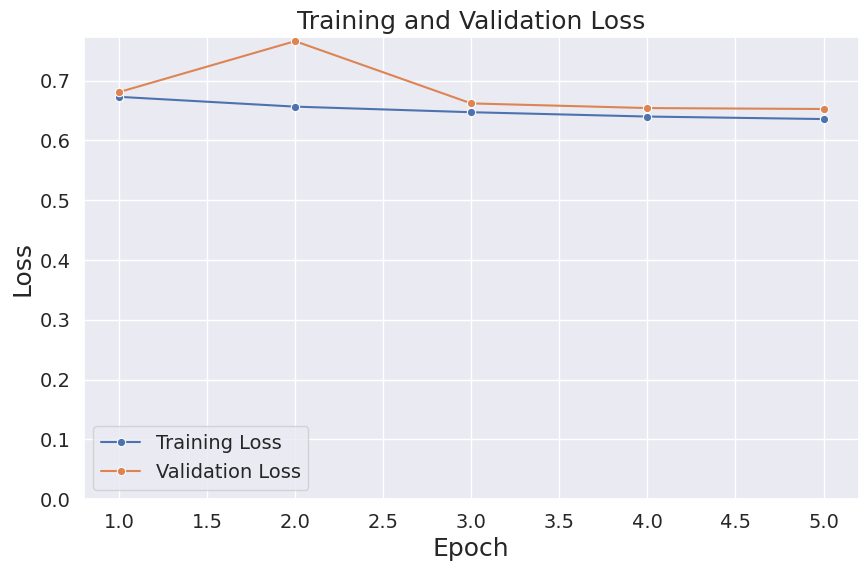

In [110]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 6), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)
ax.set_ylim(0)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [111]:
torch.save(model.state_dict(), 'models/BioClinicalBertMorgan768Clusters.pth')

### Evaluation

In [112]:
# Predicting with Test Set
print('\nEvaluation metrics for Test Set:')
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=True)
print()
y_test_true, y_test_score, y_test_pred = compute_metrics(test_outputs, test_targets, prefix="Testing")


Evaluation metrics for Test Set:
Batch 2,000  of  13,504.  Loss 0.5495  Elapsed: 0:04:54.
Batch 4,000  of  13,504.  Loss 0.6929  Elapsed: 0:09:40.
Batch 6,000  of  13,504.  Loss 0.4974  Elapsed: 0:14:25.
Batch 8,000  of  13,504.  Loss 0.6313  Elapsed: 0:19:11.
Batch 10,000  of  13,504.  Loss 0.7052  Elapsed: 0:23:56.
Batch 12,000  of  13,504.  Loss 0.7650  Elapsed: 0:28:42.

Avg Validation Loss 0.6323, Completed in 0:32:27

Testing F2-score: 0.7065
Testing Matthew Correlation Coefficient: 0.2276
Testing Recall: 0.7045
Testing Precision: 0.7148
Testing Accuracy: 0.6375


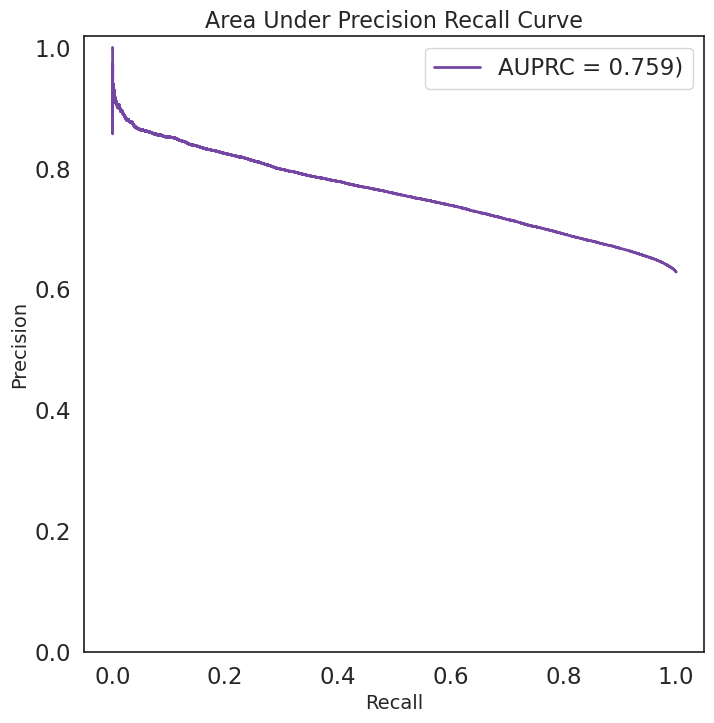

In [117]:
# Extract AUPRC & AP
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=2, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test_true, y_test_score)

In [114]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test_true, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.51      0.52      0.52     80235
     class 1       0.71      0.70      0.71    135828

    accuracy                           0.64    216063
   macro avg       0.61      0.61      0.61    216063
weighted avg       0.64      0.64      0.64    216063



In [115]:
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[52.42101327, 47.57898673],
       [29.5528168 , 70.4471832 ]])

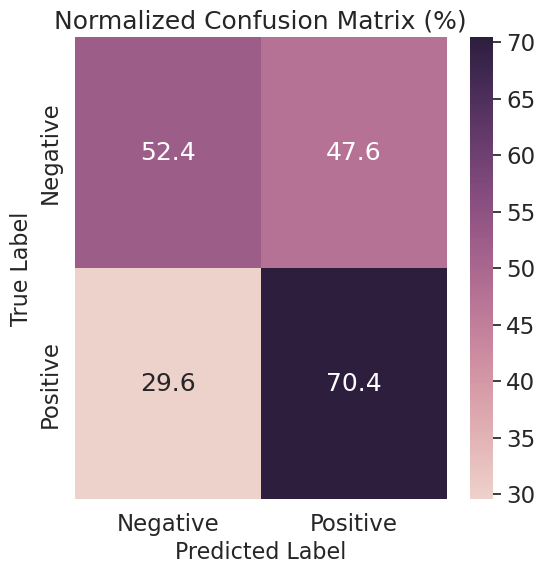

In [116]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        # fmt=',.0f'
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=16)
    ax.set_ylabel("True Label", fontsize=16)
    ax.set_title("Normalized Confusion Matrix (%)", fontsize=18)
    plt.show()

plot_conf_matrix_high(conf_matrix)

## Training Manually_ SMILES Two Branches 300 Morgan & BioClinicalBERT Unfreeze Last Layer

### Build Model

In [6]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 100
LEARNING_RATE = 0.001
# MOMENTUM = 0.9
WEIGHT_DECAY = 0.01
WORKERS = int(os.cpu_count())

In [7]:
# BERT Model
class MorganBioBertClassification(nn.Module):
    def __init__(self,output_dim=1,
                 hidden_size=68, hidden_size2=54, hidden_size3=40,
                 dropout=0.1, unfreeze=False):
        super(MorganBioBertClassification, self).__init__()
        self.bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

        # Unfreeze the last BERT transformer layer
        if unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "last two":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name or 'bert_model.encoder.layer.10' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True
        else:
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)
        self.hidden_layer2 = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3 = nn.Linear(self.hidden_size2, self.hidden_size3)

        # Morgan Embedding First hidden layer
        self.hidden_layer_morgan = nn.Linear(600, self.hidden_size)
        self.hidden_layer2_morgan = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3_morgan = nn.Linear(self.hidden_size2, self.hidden_size3)

        # One hidden Layer after combining both branches
        self.hidden_layer_combine = nn.Linear(2*self.hidden_size3, 16)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(16, output_dim)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, morgan_embedding):
        # Output for target data
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)

        pooler_token = bert_output[1]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        # Output for SMILES Morgan Embedding
        hidden_morgan_output = self.GeLU(self.hidden_layer_morgan(morgan_embedding))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)
        hidden_morgan_output = self.GeLU(self.hidden_layer2_morgan(hidden_morgan_output))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)
        hidden_morgan_output = self.GeLU(self.hidden_layer3_morgan(hidden_morgan_output))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)

        # Concatenate hidden_output and morgan_output
        concat_output = torch.cat((hidden_morgan_output, hidden_ouput), 1)
        hidden_concat_output = self.GeLU(self.hidden_layer_combine(concat_output))
        hidden_concat_output = self.drop_out(hidden_concat_output)

        # logits = self.classification(x)
        output = self.Sigmoid(self.classification(hidden_concat_output))
        output = output.flatten()

        # return logits
        return output

In [8]:
# Initialize model
model = MorganBioBertClassification(unfreeze="last layer")
model = model.to(device)

#load the pre-trained Bio-ClinicalBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Print out models params for checking
params = list(model.named_parameters())
for p in params[-30:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert_model.encoder.layer.11.attention.self.value.weight   (768, 768)
bert_model.encoder.layer.11.attention.self.value.bias         (768,)
bert_model.encoder.layer.11.attention.output.dense.weight   (768, 768)
bert_model.encoder.layer.11.attention.output.dense.bias       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.weight       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.bias       (768,)
bert_model.encoder.layer.11.intermediate.dense.weight    (3072, 768)
bert_model.encoder.layer.11.intermediate.dense.bias          (3072,)
bert_model.encoder.layer.11.output.dense.weight          (768, 3072)
bert_model.encoder.layer.11.output.dense.bias                 (768,)
bert_model.encoder.layer.11.output.LayerNorm.weight           (768,)
bert_model.encoder.layer.11.output.LayerNorm.bias             (768,)
bert_model.pooler.dense.weight                            (768, 768)
bert_model.pooler.dense.bias                                  (768,)
hidden_layer.weight   

### Build DataLoader

In [9]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary.csv'
test_file = 'data/binary_ddi/ddi_test_binary.csv'

df_train = pd.read_csv(train_file, sep='\t')
df_val= pd.read_csv(dev_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()
df_train.head(2)

mean length of smiles1: 62.479706666666665
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.77145
min length of smiles2: 3
max length of smiles2: 748
Value Counts of Labels in Train Set:


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB01156,DB00552,Bupropion,Pentostatin,#Drug1 may decrease the excretion rate of #Dru...,1,unknown,CC(NC(C)(C)C)C(=O)C1=CC(Cl)=CC=C1,OC[C@H]1O[C@H](C[C@@H]1O)N1C=NC2=C1N=CNC[C@H]2O
1,DB09414,DB00542,Dipotassium phosphate,Benazepril,The risk or severity of hyperkalemia can be in...,1,high,[K+].[K+].OP([O-])([O-])=O,[H][C@@]1(CCC2=CC=CC=C2N(CC(O)=O)C1=O)N[C@@H](...


In [10]:
from sklearn.utils import resample

# Choose a smaller subset of val data for faster training
df_val_small = resample(df_val,
                        replace=False,     # sample without replacement
                        n_samples=30000,
                        # random_state=1
                        )
print(df_val_small.shape)
df_val_small.head(2)

(30000, 9)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
146231,DB01026,DB02134,Ketoconazole,Xanthine,The metabolism of #Drug2 can be decreased when...,1,unknown,CC(=O)N1CCN(CC1)C1=CC=C(OCC2COC(CN3C=CN=C3)(O2...,O=C1NC2=C(NC=N2)C(=O)N1
24072,DB00202,DB08984,Succinylcholine,Etofenamate,The risk or severity of hyperkalemia can be in...,1,high,C[N+](C)(C)CCOC(=O)CCC(=O)OCC[N+](C)(C)C,OCCOCCOC(=O)C1=CC=CC=C1NC1=CC=CC(=C1)C(F)(F)F


In [12]:
# Import Drug2Vec Embedding - Morgan Fingerprints, Cosine Similarity
# drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname=f"data/binary_ddi/drug2vec_300clusters_morgan_cosine.txt", binary=False)
# Import Drug2Vec Embedding - Morgan Fingerprints, Tanimoto Similarity, 768 clusters
drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname=f"data/binary_ddi/drug2vec_300clusters_morgan_tanimoto.txt", binary=False)

print('Number of drugs available:', len(drug2vec_model.index_to_key))
print('Example - top 10 keys:', drug2vec_model.index_to_key[:10])
print('Embedding dimension:', len(drug2vec_model[drug2vec_model.index_to_key[0]]))

Number of drugs available: 2563
Example - top 10 keys: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Embedding dimension: 300


In [13]:
def build_data_loader(df, shuffle=True, verbose=False):
    # Extract Morgan Fingerprint Embedding
    # Remove the 4 SMILES causing error, only include SMILES in drug2vec.txt
    valid_smiles = drug2vec_model.index_to_key
    df = df[df['d1'].isin(valid_smiles) & df['d2'].isin(valid_smiles)]

    # Extract embedding
    df['d1_embedding'] = df['d1'].apply(lambda x: drug2vec_model[x])
    df['d2_embedding'] = df['d2'].apply(lambda x: drug2vec_model[x])

    # Drop all records that could not extract embedding (SMILES errors)
    df = df.dropna(subset=['d1_embedding', 'd2_embedding'], how='any')
    d1_embed = np.array(df['d1_embedding'].tolist())
    d2_embed = np.array(df['d2_embedding'].tolist())
    X_smiles = np.hstack((d1_embed, d2_embed))
    morgan_embedding = torch.from_numpy(X_smiles)
    if verbose:
        print('Drug1 Embedding Dimension:',d1_embed.shape)
        print('Drug2 Embedding Dimension:',d2_embed.shape)
        print('Drug 1 Concatenate with Drug 2 Embedding Dimension:', X_smiles.shape)
        print('Torch tensor Embedding Dimension:', morgan_embedding.shape)

    # Combine SMILES1 & SMILE2 Together, using [SEP] token to distingush between drug1 & drug2
    df["features"] = df["smiles1"].str[:254] + " [SEP] " + df["smiles2"].str[:254]
    X = df["features"]
    y = df["interaction_type"]

    # Combine Target2 and Target2 Together, using [SEP] token to distingush between drug1 & drug2
    # df["target_features"] = "Drug1: " + df["d1_target_action"] + " [SEP] " + "Drug2: " + df["d2_target_action"] + " [SEP]"
    # X_target = df["target_features"]

    # Tokenize Target
    _encodings = tokenizer(
        list(X.values),
        max_length=512,
        truncation=True,
        pad_to_max_length=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )

    _ids = _encodings.input_ids
    _mask = _encodings.attention_mask
    _labels = torch.tensor(y.values)
    if verbose:
        print('Torch tensor target_ids Dimension:', _ids.shape)
        print('Torch tensor labels Dimension:', _labels.shape)

    _dataset = TensorDataset(_ids, _mask, _labels, morgan_embedding)
    _loader = DataLoader(_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=WORKERS)

    return _loader

In [14]:
# Val Data Loader
print('Validation Data Loader:')
val_loader = build_data_loader(df_val_small, shuffle=False, verbose=True)

Validation Data Loader:
Drug1 Embedding Dimension: (29969, 300)
Drug2 Embedding Dimension: (29969, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (29969, 600)
Torch tensor Embedding Dimension: torch.Size([29969, 600])
Torch tensor target_ids Dimension: torch.Size([29969, 512])
Torch tensor labels Dimension: torch.Size([29969])


In [15]:
# Train Data Loader
print('Testing Data Loader:')
test_loader = build_data_loader(df_test, verbose=True)

Testing Data Loader:
Drug1 Embedding Dimension: (186487, 300)
Drug2 Embedding Dimension: (186487, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (186487, 600)
Torch tensor Embedding Dimension: torch.Size([186487, 600])
Torch tensor target_ids Dimension: torch.Size([186487, 512])
Torch tensor labels Dimension: torch.Size([186487])


In [16]:
# Train Data Loader
print('Training Data Loader:')
train_loader = build_data_loader(df_train, verbose=True)

Training Data Loader:
Drug1 Embedding Dimension: (299117, 300)
Drug2 Embedding Dimension: (299117, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (299117, 600)
Torch tensor Embedding Dimension: torch.Size([299117, 600])
Torch tensor target_ids Dimension: torch.Size([299117, 512])
Torch tensor labels Dimension: torch.Size([299117])


In [17]:
print('Train batches:', len(train_loader))
print('Val subset batches:', len(val_loader))
print('Test batches:', len(test_loader))

Train batches: 12464
Val subset batches: 1249
Test batches: 7771


### Training
#### Learning Rate Finder

In [18]:
model = MorganBioBertClassification()
model = model.to(device)

# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
# optimizer = optim.Adadelta(model.parameters(), lr=1e-7, weight_decay=1e-2)
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-2)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# Function to adjust the Learning Rate manually for Finding a good learning rate
# Increase LR from 1e-7 to 10 in exponential manner
n_step_lr = 100
learning_rates = np.logspace(-7, 0, n_step_lr)

def adjust_learning_rate(optimizer, step):
    """This function is for testing different learning rate in an epoch to find the best LR range"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rates[step]

learning_rates

array([1.00000000e-07, 1.17681195e-07, 1.38488637e-07, 1.62975083e-07,
       1.91791026e-07, 2.25701972e-07, 2.65608778e-07, 3.12571585e-07,
       3.67837977e-07, 4.32876128e-07, 5.09413801e-07, 5.99484250e-07,
       7.05480231e-07, 8.30217568e-07, 9.77009957e-07, 1.14975700e-06,
       1.35304777e-06, 1.59228279e-06, 1.87381742e-06, 2.20513074e-06,
       2.59502421e-06, 3.05385551e-06, 3.59381366e-06, 4.22924287e-06,
       4.97702356e-06, 5.85702082e-06, 6.89261210e-06, 8.11130831e-06,
       9.54548457e-06, 1.12332403e-05, 1.32194115e-05, 1.55567614e-05,
       1.83073828e-05, 2.15443469e-05, 2.53536449e-05, 2.98364724e-05,
       3.51119173e-05, 4.13201240e-05, 4.86260158e-05, 5.72236766e-05,
       6.73415066e-05, 7.92482898e-05, 9.32603347e-05, 1.09749877e-04,
       1.29154967e-04, 1.51991108e-04, 1.78864953e-04, 2.10490414e-04,
       2.47707636e-04, 2.91505306e-04, 3.43046929e-04, 4.03701726e-04,
       4.75081016e-04, 5.59081018e-04, 6.57933225e-04, 7.74263683e-04,
      

In [20]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [21]:
import math

## Define Learning Rate Finding fuction
def train_LRFinder(train_loader, model, criterion, optimizer, verbose=True):
    # reset total loss for each epoch
    total_loss = 0

    # LR Finding initialization
    losses = []
    lrs = []
    loss_100iters = 0


    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader):
        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)
        morgan_embedding = data[3].to(device)
    
        # compute output
        output = model(input_ids=ids, 
                       attention_mask=mask,
                       morgan_embedding=morgan_embedding
                      )

        # compute loss
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches
        total_loss += loss.item()
        loss_100iters += loss.item()

        # compute gradient
        # backprop!
        loss.backward()

        # update the weights!
        optimizer.step()

        # Report progress
        update_lr_step = int(math.ceil(len(train_loader)/n_step_lr))  #step = 125
        if step % update_lr_step == 0 and not step == 0 and verbose==True:
            n_iter_lr = int(step//update_lr_step)
            # Average loss for the current LR
            loss_100iters = loss_100iters / update_lr_step
            lr = learning_rates[n_iter_lr]

            print('Batch {:>5,}  of  {:>5,}.   Step Loss {:0.4f}   Avg Loss {:0.4f}   Learning Rate {:}    Elapsed: {:}.'.format(
                step,
                len(train_loader),
                loss.item(),
                loss_100iters,
                lr,
                format_time(time.time() - t0)))

            # Add loss & lr to list for ploting later
            losses.append(loss_100iters)
            lrs.append(lr)

            # update learning rate
            # scheduler.step()
            adjust_learning_rate(optimizer, n_iter_lr)

            # Reset loss for next lr
            loss_100iters = 0

    # Last iteration
    resid = len(train_loader) - 125*(n_step_lr-1)
    loss_100iters = loss_100iters / resid
    # Add loss & lr to list for ploting later
    losses.append(loss_100iters)
    lrs.append(learning_rates[-1])

    avg_train_loss = total_loss / len(train_loader)
    elapsed_time = time.time() - t0
    if verbose:
        print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
            avg_train_loss,
            format_time(elapsed_time)
        ))

    # return model, avg_train_loss, elapsed_time
    return losses, lrs

In [23]:
os.environ["TOKENIZERS_PARALLELISM"] = "TRUE"

In [24]:
print ('-----  Learning Rate Finder -----')
losses, lrs = train_LRFinder(train_loader, model, criterion, optimizer)
print('Losses Dim:', len(losses))
print('LR Dim:', len(lrs))

-----  Learning Rate Finder -----
Batch   125  of  12,464.   Step Loss 0.7160   Avg Loss 0.7036   Learning Rate 1.1768119524349991e-07    Elapsed: 0:01:42.
Batch   250  of  12,464.   Step Loss 0.7248   Avg Loss 0.6974   Learning Rate 1.3848863713938718e-07    Elapsed: 0:02:11.
Batch   375  of  12,464.   Step Loss 0.7163   Avg Loss 0.6974   Learning Rate 1.6297508346206436e-07    Elapsed: 0:02:40.
Batch   500  of  12,464.   Step Loss 0.6993   Avg Loss 0.6984   Learning Rate 1.9179102616724887e-07    Elapsed: 0:03:08.
Batch   625  of  12,464.   Step Loss 0.6806   Avg Loss 0.7002   Learning Rate 2.2570197196339216e-07    Elapsed: 0:03:37.
Batch   750  of  12,464.   Step Loss 0.6824   Avg Loss 0.7007   Learning Rate 2.656087782946684e-07    Elapsed: 0:04:06.
Batch   875  of  12,464.   Step Loss 0.6991   Avg Loss 0.6999   Learning Rate 3.125715849688235e-07    Elapsed: 0:04:35.
Batch 1,000  of  12,464.   Step Loss 0.7071   Avg Loss 0.6987   Learning Rate 3.678379771828634e-07    Elapsed: 0:

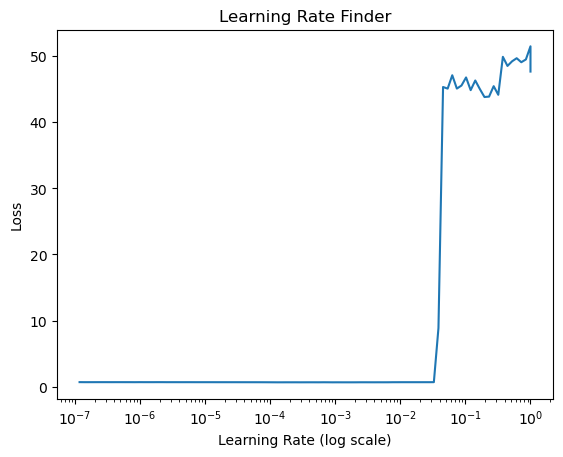

In [25]:
plt.title("Learning Rate Finder")
plt.ylabel("Loss")
plt.xlabel("Learning Rate (log scale)")
plt.plot(lrs, losses)
plt.xscale('log')

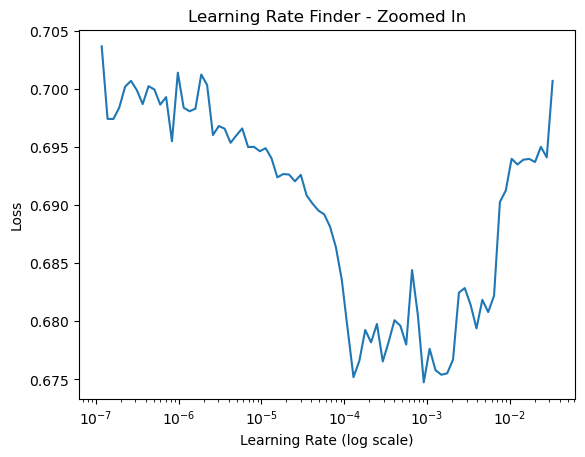

In [29]:
plt.title("Learning Rate Finder - Zoomed In")
plt.ylabel("Loss")
plt.xlabel("Learning Rate (log scale)")
plt.plot(lrs[:78], losses[:78])
plt.xscale('log')

#### Training with Best LR

In [30]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 100
LEARNING_RATE = 0.002
WEIGHT_DECAY = 1e-2
WORKERS = int(os.cpu_count())

In [31]:
# from transformers import get_linear_schedule_with_warmup
# Initialize Model
model = MorganBioBertClassification(unfreeze="last layer")

# Continue training
model = model.to(device)
# checkpoint = torch.load("models/checkpoint.pth.tar")
# model.load_state_dict(checkpoint['state_dict'])

# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
# optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min = 5e-6)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*T_max, num_training_steps=T_max)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
## Define train function
def train(train_loader, model, criterion, optimizer, verbose=True):
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader):
        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)   # 1 head
        # target = data[2].to(device, dtype = torch.long)   # 2 heads
        morgan_embedding = data[3].to(device)
    
        # compute output
        output = model(input_ids=ids, 
                       attention_mask=mask,
                       morgan_embedding=morgan_embedding
                      )

        # compute loss
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches
        total_loss += loss.item()

        # Report progress every 200 batches
        if step % 1000 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                step,
                len(train_loader),
                loss.item(),
                format_time(time.time() - t0)))

        # compute gradient and do SGD
        # backprop!
        loss.backward()

        # update the weights!
        optimizer.step()

        # update learning rate with scheduler
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    elapsed_time = time.time() - t0
    if verbose:
        print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
            avg_train_loss,
            format_time(elapsed_time)
        ))

    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time

In [33]:
## Define validate function
def validate(val_loader, model, criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for step, data in enumerate(val_loader):

            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            target = data[2].float().to(device)
            morgan_embedding = data[3].to(device)
        
            # compute output
            output = model(input_ids=ids, 
                           attention_mask=mask,
                           morgan_embedding=morgan_embedding
                          )

            # compute loss
            loss = criterion(output, target)

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 1000 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step,
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
        print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
            avg_val_loss,
            format_time(elapsed_time)
        ))

    return outputs, targets, avg_val_loss, elapsed_time


In [38]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
def compute_metrics(outputs, targets, prefix="Training"):
    y_pred = (np.array(outputs) >= 0.5).astype(float)
    y_score = np.array(outputs)
    y_true = np.array(targets)

    f2 =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")

    return y_true, y_score, y_pred, accuracy_macro

In [39]:
os.environ["TOKENIZERS_PARALLELISM"] = "TRUE"

In [40]:
filename = "models/checkpoint.pth.tar"

def save_checkpoint(state, is_best, filename=filename):
    torch.save(state, filename)

    if is_best:
        shutil.copyfile(filename, 'models/model_best.pth.tar')


In [41]:
##### Test LR = 0.002, Optim = AdamW, Seed=13
# Store the average loss after each epoch so we can plot them.
best_accuracy = 0
train_loss_values = []
val_loss_values = []
learning_rates = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print('Learning rate:', str(scheduler.get_last_lr()[0]))
    print()
    learning_rates.append(scheduler.get_last_lr())

    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred, val_accuracy = compute_metrics(val_outputs, val_targets, prefix="Validation")
    print()

    # Get the best loss
    is_best = val_accuracy > best_accuracy
    best_accuracy = max(val_accuracy, best_accuracy)

    # Save Checkpoint
    save_checkpoint(
        {'epoch': epoch+1,
         'state_dict': model.state_dict(),
         'best_accuracy': best_accuracy,
         'optimizer': optimizer.state_dict()
         },
        is_best
    )

    if train_loss < 0.2:
        break

######  Epoch 1/100 ######
Learning rate: 0.001999507793964797

-----  Training -----
Batch 1,000  of  12,464.  Loss 0.6949  Elapsed: 0:03:52.
Batch 2,000  of  12,464.  Loss 0.6019  Elapsed: 0:07:42.
Batch 3,000  of  12,464.  Loss 0.6302  Elapsed: 0:11:33.
Batch 4,000  of  12,464.  Loss 0.6300  Elapsed: 0:15:23.
Batch 5,000  of  12,464.  Loss 0.5749  Elapsed: 0:19:14.
Batch 6,000  of  12,464.  Loss 0.7150  Elapsed: 0:23:04.
Batch 7,000  of  12,464.  Loss 0.5848  Elapsed: 0:26:55.
Batch 8,000  of  12,464.  Loss 0.7129  Elapsed: 0:30:45.
Batch 9,000  of  12,464.  Loss 0.6908  Elapsed: 0:34:36.
Batch 10,000  of  12,464.  Loss 0.6556  Elapsed: 0:38:26.
Batch 11,000  of  12,464.  Loss 0.5604  Elapsed: 0:42:16.
Batch 12,000  of  12,464.  Loss 0.5803  Elapsed: 0:46:07.

Avg Training Loss 0.6475, Completed in 0:47:55 

-----  Validation -----
Batch 1,000  of  1,249.  Loss 0.8059  Elapsed: 0:03:29.

Avg Validation Loss 0.6733, Completed in 0:04:22
Validation F2-score: 0.7663
Validation Matthew 

KeyboardInterrupt: 

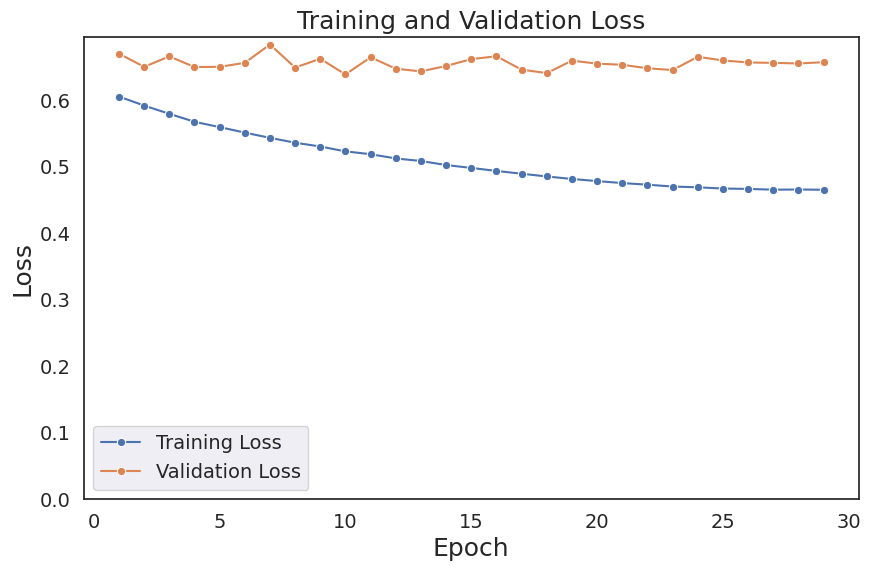

In [74]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 30), 'Training Loss': train_loss_values[:29], 'Validation Loss': val_loss_values[:29]}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)
ax.set_ylim(0)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [42]:
checkpoint = torch.load("model_best_morgan_biobert_unfreeze_ep1.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Evaluation

In [43]:
# Predicting with Test Set # First 29 epochs
print('Evaluation metrics for Test Set:')
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=True)
print()
y_test_true, y_test_score, y_test_pred = compute_metrics(test_outputs, test_targets, prefix="Testing")

Evaluation metrics for Test Set:
Batch 1,000  of  7,771.  Loss 0.7089  Elapsed: 0:03:30.
Batch 2,000  of  7,771.  Loss 0.5627  Elapsed: 0:06:58.
Batch 3,000  of  7,771.  Loss 0.5983  Elapsed: 0:10:27.
Batch 4,000  of  7,771.  Loss 0.5980  Elapsed: 0:13:56.
Batch 5,000  of  7,771.  Loss 0.6935  Elapsed: 0:17:24.
Batch 6,000  of  7,771.  Loss 0.6844  Elapsed: 0:20:53.
Batch 7,000  of  7,771.  Loss 0.7269  Elapsed: 0:24:21.

Avg Validation Loss 0.6369, Completed in 0:27:03

Testing F2-score: 0.7708
Testing Matthew Correlation Coefficient: 0.137
Testing Recall: 0.7888
Testing Precision: 0.7062
Testing Accuracy: 0.6393


ValueError: too many values to unpack (expected 3)

In [44]:
y_test_true, y_test_score, y_test_pred, accuracy = compute_metrics(test_outputs, test_targets, prefix="Testing")

Testing F2-score: 0.7708
Testing Matthew Correlation Coefficient: 0.137
Testing Recall: 0.7888
Testing Precision: 0.7062
Testing Accuracy: 0.6393


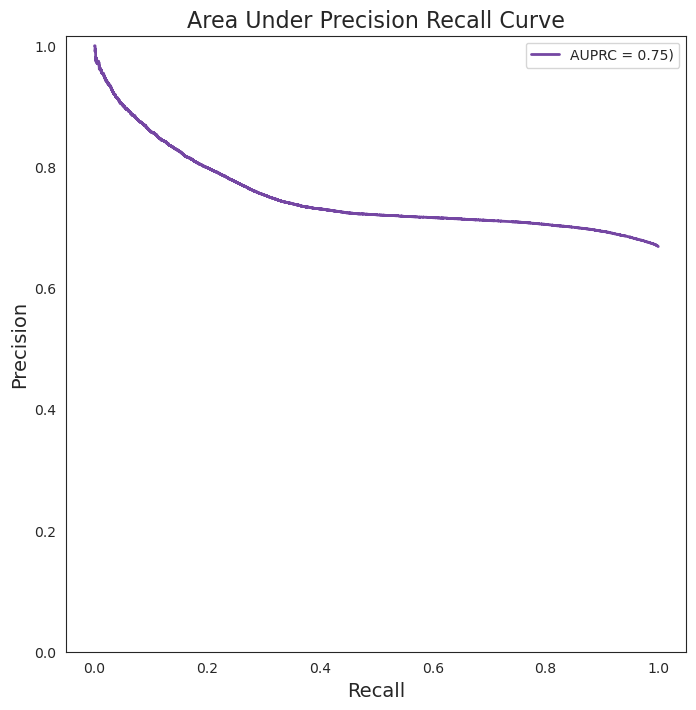

In [45]:
# Extract AUPRC & AP
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=2, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test_true, y_test_score)

In [46]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test_true, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.44      0.34      0.38     61798
     class 1       0.71      0.79      0.75    124689

    accuracy                           0.64    186487
   macro avg       0.57      0.56      0.56    186487
weighted avg       0.62      0.64      0.63    186487



In [47]:
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[33.77779216, 66.22220784],
       [21.11894393, 78.88105607]])

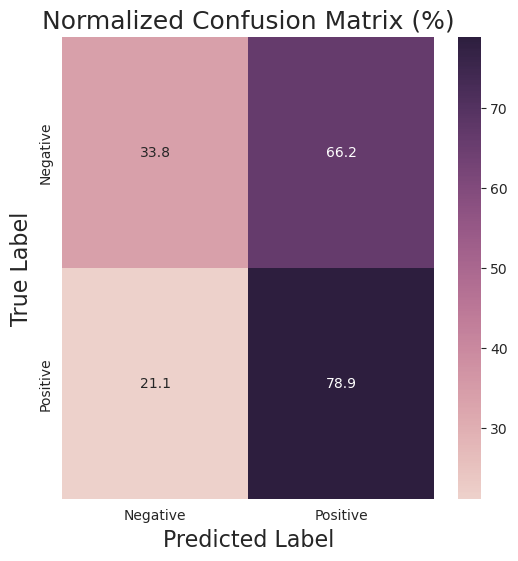

In [48]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        # fmt=',.0f'
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=16)
    ax.set_ylabel("True Label", fontsize=16)
    ax.set_title("Normalized Confusion Matrix (%)", fontsize=18)
    plt.show()

plot_conf_matrix_high(conf_matrix)